In [1]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.1'
spark_version = 'spark-3.1.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NaiveBayes").getOrCreate()

In [3]:
import pandas as pd
url = 'https://raw.githubusercontent.com/lisb020/scifi_book_game/main/BookList.csv'
pd_df = pd.read_csv(url)

pd_df.head()

,Unnamed: 0,Book_Title,Rating_score,Rating_votes,Book_Description,subgenre
0,0,Obsidian,4.17,236780,Starting over sucks When we moved to West Virg...,sf_aliens
1,1,Onyx,4.27,153429,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,sf_aliens
2,2,The 5th Wave,4.03,400600,After the 1st wave only darkness remains Aft...,sf_aliens
3,3,The Host,3.84,915026,Melanie Stryder refuses to fade away The eart...,sf_aliens
4,5,Origin,4.35,93979,Daemon will do anything to get Katy back After...,sf_aliens


In [4]:
pd_df.drop(columns="Unnamed: 0", inplace=True)
pd_df.head()

,Book_Title,Rating_score,Rating_votes,Book_Description,subgenre
0,Obsidian,4.17,236780,Starting over sucks When we moved to West Virg...,sf_aliens
1,Onyx,4.27,153429,BEING CONNECTED TO DAEMON BLACK SUCKS… Thanks ...,sf_aliens
2,The 5th Wave,4.03,400600,After the 1st wave only darkness remains Aft...,sf_aliens
3,The Host,3.84,915026,Melanie Stryder refuses to fade away The eart...,sf_aliens
4,Origin,4.35,93979,Daemon will do anything to get Katy back After...,sf_aliens


In [5]:
# def group_rating(row):
#   return(str(row['Rating_score']).split('.')[0])

# pd_df['rating'] = pd_df.apply (lambda row: group_rating(row), axis=1) 

In [7]:
import math
def round_down(row):
    return str(math.floor(row['Rating_score']))


pd_df['rating'] = pd_df.apply (lambda row: round_down(row), axis=1) 

In [8]:
def remove_nums(row):
  output = ''.join(c for c in str(row['Book_Description']) if not c.isdigit())
  return(output)

pd_df['Book_Description'] = pd_df.apply (lambda row: remove_nums(row), axis=1) 

In [9]:
def remove_multi_spaces(row):
  single_spaces = " ".join(str(row['Book_Description']).split())
  return(single_spaces)

pd_df['Book_Description'] = pd_df.apply (lambda row: remove_multi_spaces(row), axis=1)   

In [10]:
def remove_unicode(row):
  string_encode = str(row['Book_Description']).encode("ascii", "ignore")
  return(string_encode.decode())

pd_df['Book_Description'] = pd_df.apply (lambda row: remove_unicode(row), axis=1) 

In [11]:
pd_df['subgenre'].unique()

array(['sf_aliens', 'sf_alternate_history', 'sf_alternate_universe',
       'sf_apocalyptic', 'sf_cyberpunk', 'sf_dystopia', 'sf_hard',
       'sf_military', 'sf_robots', 'sf_space_opera', 'sf_steampunk',
       'sf_time_travel'], dtype=object)

In [12]:
from pyspark.sql.types import *
mySchema = StructType([ StructField("Book_Title", StringType(), True)\
                       ,StructField("Rating_score", FloatType(), True)\
                       ,StructField("Rating_votes", LongType(), True)\
                       ,StructField("Book_Description", StringType(), True)\
                       ,StructField("subgenre", StringType(), True)\
                       ,StructField("rating", StringType(), True)])

In [13]:
spark_df = spark.createDataFrame(pd_df, schema=mySchema)
spark_df.show(50)

+--------------------+------------+------------+--------------------+---------+------+
|          Book_Title|Rating_score|Rating_votes|    Book_Description| subgenre|rating|
+--------------------+------------+------------+--------------------+---------+------+
|            Obsidian|        4.17|      236780|Starting over suc...|sf_aliens|     4|
|                Onyx|        4.27|      153429|BEING CONNECTED T...|sf_aliens|     4|
|        The 5th Wave|        4.03|      400600|After the st wave...|sf_aliens|     4|
|            The Host|        3.84|      915026|Melanie Stryder r...|sf_aliens|     3|
|              Origin|        4.35|       93979|Daemon will do an...|sf_aliens|     4|
|          Opposition|        4.37|       67740|Katy knows the wo...|sf_aliens|     4|
|    I Am Number Four|        3.94|      319092|Nine of us came h...|sf_aliens|     3|
|    The Infinite Sea|        3.87|      123001|How do you rid th...|sf_aliens|     3|
|             Shadows|        4.12|       3

In [14]:
from pyspark.sql.functions import length
# Create a length column to be used as a future feature 
data_df = spark_df.withColumn('length', length(spark_df['Book_Description']))
data_df.show()

+--------------------+------------+------------+--------------------+---------+------+------+
|          Book_Title|Rating_score|Rating_votes|    Book_Description| subgenre|rating|length|
+--------------------+------------+------------+--------------------+---------+------+------+
|            Obsidian|        4.17|      236780|Starting over suc...|sf_aliens|     4|   830|
|                Onyx|        4.27|      153429|BEING CONNECTED T...|sf_aliens|     4|   987|
|        The 5th Wave|        4.03|      400600|After the st wave...|sf_aliens|     4|   691|
|            The Host|        3.84|      915026|Melanie Stryder r...|sf_aliens|     3|   580|
|              Origin|        4.35|       93979|Daemon will do an...|sf_aliens|     4|   858|
|          Opposition|        4.37|       67740|Katy knows the wo...|sf_aliens|     4|   828|
|    I Am Number Four|        3.94|      319092|Nine of us came h...|sf_aliens|     3|   716|
|    The Infinite Sea|        3.87|      123001|How do you r

In [16]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
import nltk
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words("english")

namesurl = 'https://raw.githubusercontent.com/lisb020/scifi_book_game/main/names_data.csv'
names_df = pd.read_csv(namesurl)

list_of_names = names_df['name'].to_list()
name_list = []
for name in list_of_names:
    name_list.append(name.lower())

stop_words.extend(name_list)
number_words =["one","two","three","four","five","six","seven","eight","nine","ten"]
stop_words.extend(number_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Create all the features to the data set

# select the feature to categorize
rating_to_num = StringIndexer(inputCol='rating',outputCol='label')
#sub_genre = StringIndexer(inputCol='subgenre',outputCol='label')

#prepare the Book Description Data as a feature
tokenizer = Tokenizer(inputCol="Book_Description", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens',stopWords=stop_words)
hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token')
idf = IDF(inputCol='hash_token', outputCol='idf_token')

In [18]:
#prepare the Book Title data as a feature
titletokenizer = Tokenizer(inputCol="Book_Title", outputCol="token_title")
titlestopremove = StopWordsRemover(inputCol='token_title',outputCol='stop_title_tokens')
titlehashingTF = HashingTF(inputCol="stop_title_tokens", outputCol='hash_title_token')
titleidf = IDF(inputCol='hash_title_token', outputCol='idf_title_token')

In [19]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

# Create feature vectors
#clean_up = VectorAssembler(inputCols=['idf_token'], outputCol='features')
#clean_up = VectorAssembler(inputCols=['idf_title_token'], outputCol='features')
clean_up = VectorAssembler(inputCols=['idf_token','idf_title_token'], outputCol='features')
#clean_up = VectorAssembler(inputCols=['idf_token'], outputCol='features')

In [20]:
# Create a and run a data processing Pipeline
from pyspark.ml import Pipeline
#data_prep_pipeline = Pipeline(stages=[sub_genre, tokenizer, stopremove, hashingTF, idf, clean_up])
#data_prep_pipeline = Pipeline(stages=[sub_genre, titletokenizer, titlestopremove, titlehashingTF, titleidf,clean_up])
#data_prep_pipeline = Pipeline(stages=[sub_genre, tokenizer, stopremove, hashingTF, idf,titletokenizer, titlestopremove, titlehashingTF, titleidf,clean_up])

#data_prep_pipeline = Pipeline(stages=[rating_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])
#data_prep_pipeline = Pipeline(stages=[rating_to_num, titletokenizer, titlestopremove, titlehashingTF, titleidf, clean_up])
data_prep_pipeline = Pipeline(stages=[rating_to_num, tokenizer, stopremove, hashingTF, idf,titletokenizer, titlestopremove, titlehashingTF, titleidf,clean_up])

In [21]:
cleaner = data_prep_pipeline.fit(data_df)
cleaned = cleaner.transform(data_df)

In [22]:
# Show label and resulting features
#cleaned.select(['label', 'features']).show(50)
cleaned.select(['stop_tokens']).show(10,truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|stop_tokens                                                                                                                                                                                                     

In [23]:
from pyspark.ml.classification import NaiveBayes
# Break data down into a training set and a testing set
training, testing = cleaned.randomSplit([0.7, 0.3])

# Create a Naive Bayes model and fit training data
nb = NaiveBayes()
predictor = nb.fit(training)

In [24]:
# Tranform the model with the testing data
test_results = predictor.transform(testing)
test_results['rating','prediction'].show(20,truncate=False)

+------+----------+
|rating|prediction|
+------+----------+
|4     |0.0       |
|3     |0.0       |
|4     |0.0       |
|3     |0.0       |
|3     |0.0       |
|3     |0.0       |
|4     |0.0       |
|4     |1.0       |
|3     |0.0       |
|3     |0.0       |
|3     |0.0       |
|3     |0.0       |
|3     |0.0       |
|3     |0.0       |
|3     |1.0       |
|3     |0.0       |
|3     |1.0       |
|3     |1.0       |
|3     |0.0       |
|3     |0.0       |
+------+----------+
only showing top 20 rows



In [25]:
## Use the Class Evaluator for a cleaner description
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(test_results)
#print("Accuracy of model at predicting subgenre based on description was: %f" % acc)
#print("Accuracy of model at predicting subgenre based on title was: %f" % acc)
print("Accuracy of model at predicting rating based on description was: %f" % acc)
#print("Accuracy of model at predicting rating based on title was: %f" % acc)
#print("Accuracy of model at predicting rating based on description AND title was: %f" % acc)

Accuracy of model at predicting rating based on description was: 0.658070


In [55]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer as kerasTokenizer
MAX_NB_WORDS = 50000
# This is fixed.
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 250

tokenizer = kerasTokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(pd_df['Book_Description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 57398 unique tokens.


In [56]:

X = tokenizer.texts_to_sequences(pd_df['Book_Description'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (10240, 250)


In [75]:
Y = pd.get_dummies(pd_df['subgenre']).values
print('Shape of label tensor:', Y.shape)
print(Y)

Shape of label tensor: (10240, 12)
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9216, 250) (9216, 12)
(1024, 250) (1024, 12)


In [62]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1212      
Total params: 5,081,612
Trainable params: 5,081,612
Non-trainable params: 0
_________________________________________________________________
None


In [79]:

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0012)])

Epoch 1/5
130/130 [==============================] - 83s 636ms/step - loss: 0.4415 - accuracy: 0.8685 - val_loss: 2.1095 - val_accuracy: 0.4252
Epoch 2/5
130/130 [==============================] - 82s 634ms/step - loss: 0.3082 - accuracy: 0.9044 - val_loss: 2.2316 - val_accuracy: 0.4187
Epoch 3/5
130/130 [==============================] - 83s 636ms/step - loss: 0.2039 - accuracy: 0.9433 - val_loss: 2.2982 - val_accuracy: 0.4317
Epoch 4/5
130/130 [==============================] - 83s 635ms/step - loss: 0.1458 - accuracy: 0.9567 - val_loss: 2.5536 - val_accuracy: 0.4534
Epoch 5/5
130/130 [==============================] - 83s 635ms/step - loss: 0.1188 - accuracy: 0.9677 - val_loss: 2.4710 - val_accuracy: 0.4479


In [80]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

32/32 [==============================] - 2s 63ms/step - loss: 2.3977 - accuracy: 0.4932
Test set
  Loss: 2.398
  Accuracy: 0.493


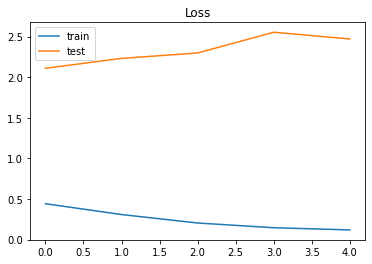

In [81]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

{'loss': [0.44153082370758057, 0.3082120418548584, 0.20392121374607086, 0.14579524099826813, 0.11881750822067261], 'accuracy': [0.8684591054916382, 0.9043887257575989, 0.9433325529098511, 0.9567157030105591, 0.9676874876022339], 'val_loss': [2.109525203704834, 2.2315726280212402, 2.2982335090637207, 2.5535542964935303, 2.470987319946289], 'val_accuracy': [0.4251627027988434, 0.4186550974845886, 0.43167027831077576, 0.45336225628852844, 0.44793927669525146]}


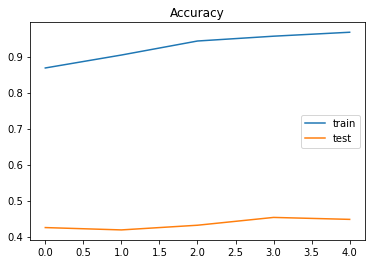

In [82]:
print(history.history)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [94]:

import numpy as np 
new_desc = ["Jaime never expected his software to change the world. "]
seq = tokenizer.texts_to_sequences(new_desc)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = pd_df["subgenre"].unique()

print(pred, labels[np.argmax(pred)])

[[0.01457144 0.08812165 0.12246091 0.147283   0.15740344 0.09710019
  0.12965041 0.00824092 0.09813927 0.01727903 0.10468029 0.01506942]] sf_cyberpunk
